In [1]:
import pywt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cPickle as pkl
import pandas as pd
import cufflinks as cf
import sys
sys.path
sys.path.append('../../benchmarking')
import prep
import prep.noise_reduct

In [2]:
with open('../../../data/locs.tsv', 'r') as f_handle:
    chan_locs = pd.read_csv(f_handle, delimiter='\t').as_matrix()
    chan_locs = np.array(chan_locs[3:, 1:])
with open('../../../data/sub-0001_trial-01.pkl', 'rb') as f_handle:
    f_real = pkl.load(f_handle)
    f_real = f_real - np.mean(f_real, axis = 1).reshape(-1, 1)
wave = 'db2'
f_real_den = prep.noise_reduct.wavelet_sureshrink(f_real, wave)
C = [pywt.wavedec(f_real[c, :], wave) for c in range(f_real.shape[0])]
C_den = [pywt.wavedec(f_real_den[c, :], wave) for c in range(f_real.shape[0])]

.


In [3]:
from math import radians, cos, sin, asin, sqrt
import copy

def haversine(rad, lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    return c * rad

def gc(coords, i, j, r):
    t = coords[i][0]
    t_ = coords[j][0]
    p = coords[i][1]
    p_ = coords[j][1]
    args = {'rad' : r, 'lon1' : t,
      'lat1' : p, 'lon2' : t_, 'lat2': p_}
    return haversine(**args)

def closest(chan, chan_locs, candidates, k):
    distances = map(lambda c: gc(chan_locs, chan, c, 1), candidates)
    closest = candidates[np.argsort(distances)[:k]]
    return distances, closest

def interp(bad_chans, coeffs, chan_locs, k):
    coefficients = copy.deepcopy(coeffs)
    candidates = np.setdiff1d(np.arange(128), bad_chans)
    for bc in bad_chans:
        distances, close = closest(bc, chan_locs, candidates, k)
        tot = np.sum(np.array(distances)[close])
        print 'bad chan =', bc, ',', 'closest =', close
        for i in range(len(coefficients[bc])):
            coefficients[bc][i] = np.sum([coefficients[cl][i] * (gc(chan_locs, bc, cl, 1)/tot) for cl in close], axis=0)
    return coefficients

def level(C, level):
    return np.array([c[level] for c in C])

def get_bad(C):
    bad_chans = np.arange(128)
    for i in range(len(C_den[0])):
        mu = np.mean(level(C_den, i), axis = 0)
        sig = np.std(level(C_den, i), axis = 0)
        zscores = [0] * 128
        for c in range(128):
            x = level(C_den, i)[c, :]
            d = (x - mu) / sig
            zscores[c] = zscores[c] + (np.linalg.norm(d, 3) / (i + 1))
    sns.distplot(zscores)
    plt.show()
    bad_chans = np.arange(128)[np.array(zscores) > 6]
    return bad_chans

In [4]:
def heat_level(C, level, title, left = False, right = False):
    L = np.array([c[level] for c in C])
    L = np.log(np.abs(L)) * np.sign(L)
    ax = sns.heatmap(L, xticklabels = L.shape[1] / 4 + 1, yticklabels = 4)
    plt.xlabel('Wavelet Coefficient k index')
    if left:
        plt.ylabel('Channel Number')
    if right:
        cbar = ax.collections[0].colorbar
        cbar.set_label(r"$sgn(\psi_{j, k})\sqrt{\vert\psi_{j, k}\vert}$", labelpad=20, rotation=270)
    plt.title(title + ', j = ' + str(level))
    
def dist_plot(C, level, label, kde = False):
    L = np.array([c[level] for c in C])
    L = np.nan_to_num(np.log(np.abs(L)) * np.sign(L))
    sns.distplot(L.flatten(), kde = kde, label = label)

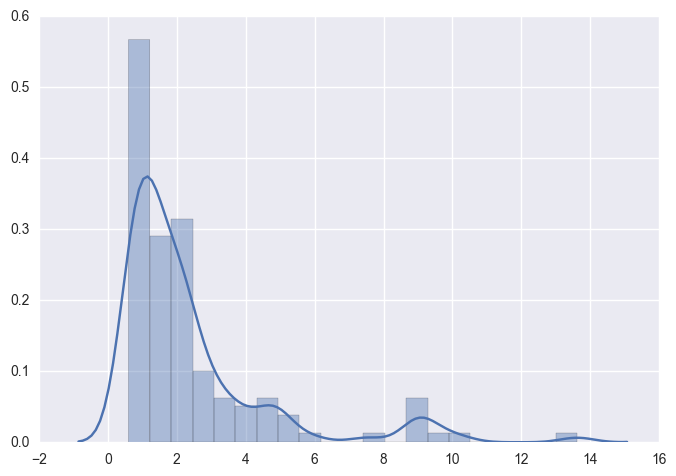

bad chan = 7 , closest = [ 8 12]
bad chan = 16 , closest = [20 19]
bad chan = 31 , closest = [36 26]
bad chan = 61 , closest = [50 51]
bad chan = 71 , closest = [65 69]
bad chan = 112 , closest = [108 113]
bad chan = 125 , closest = [22 21]
bad chan = 126 , closest = [26 36]
bad chan = 127 , closest = [104   5]
(128, 162228)


In [ ]:
bad_chans = get_bad(C_den)
C_int = interp(bad_chans, C_den, chan_locs, 2)
f_real_int = np.vstack([pywt.waverec(c, wave) for c in C_int])
print f_real_int.shape

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: RuntimeWarning:

invalid value encountered in multiply



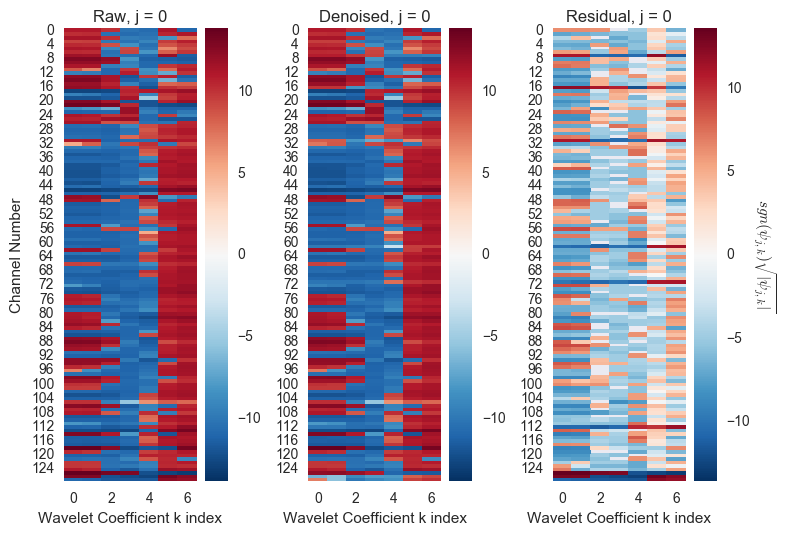

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: RuntimeWarning:

invalid value encountered in multiply



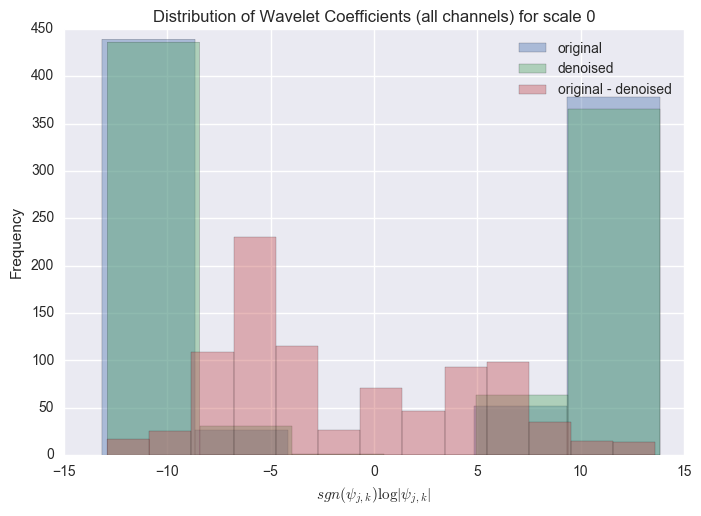

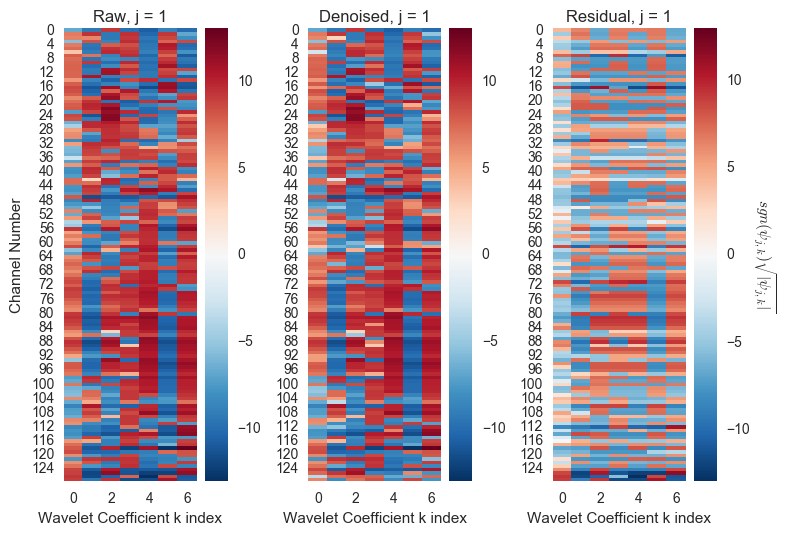

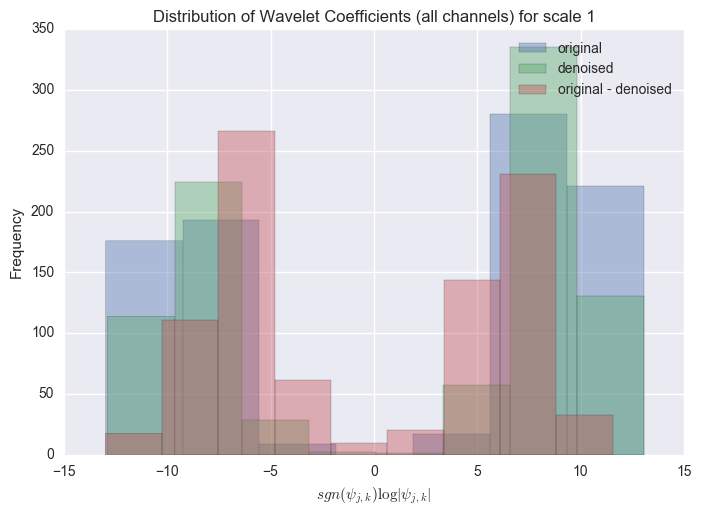

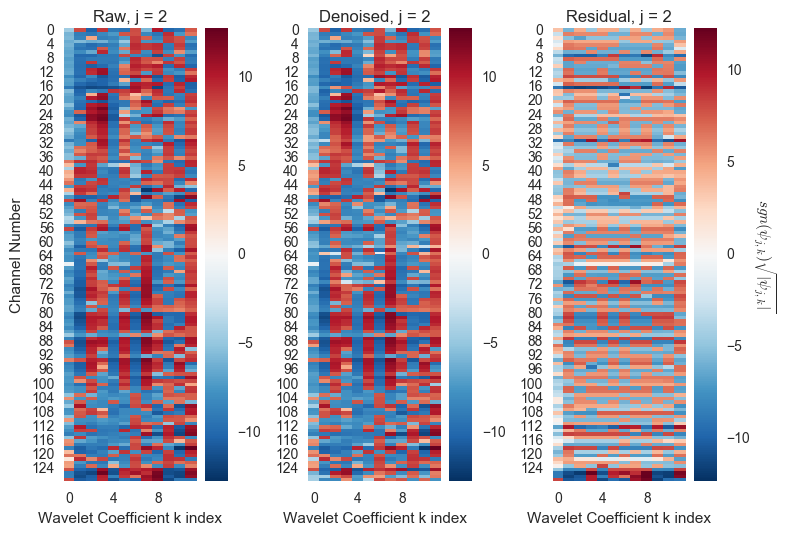

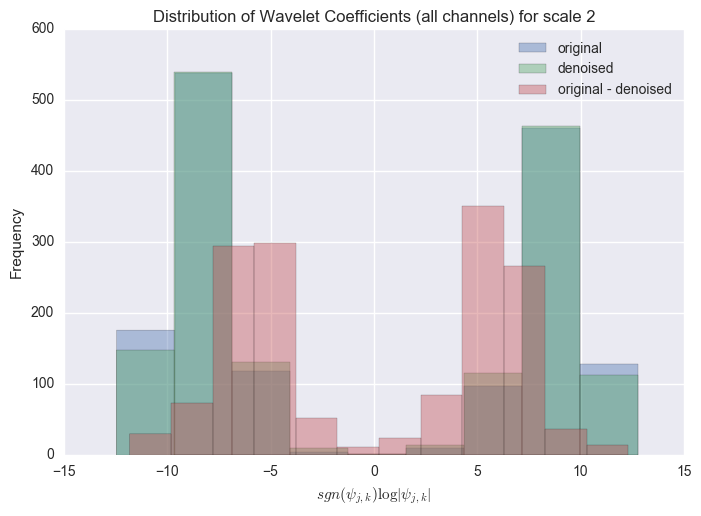

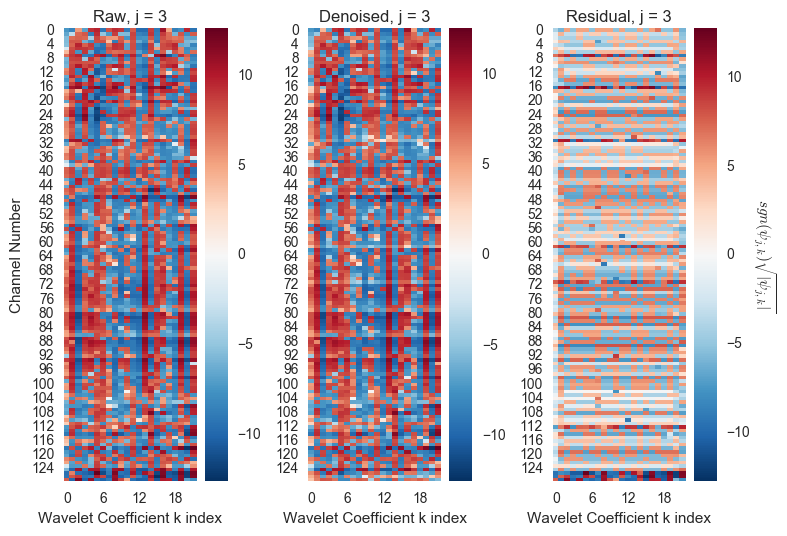

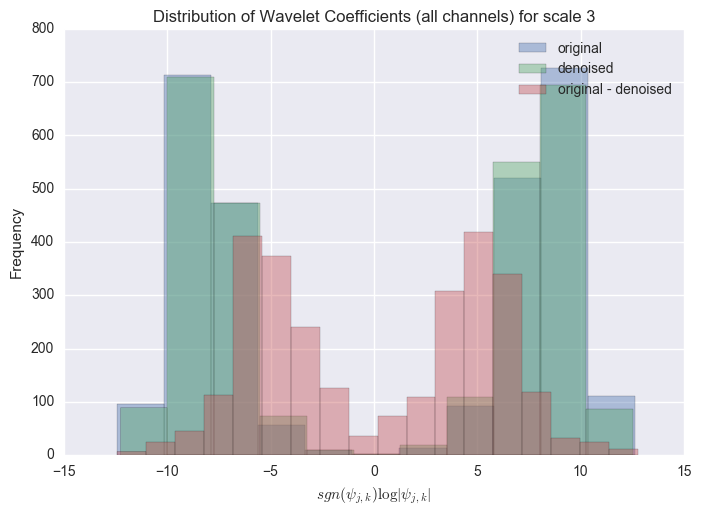

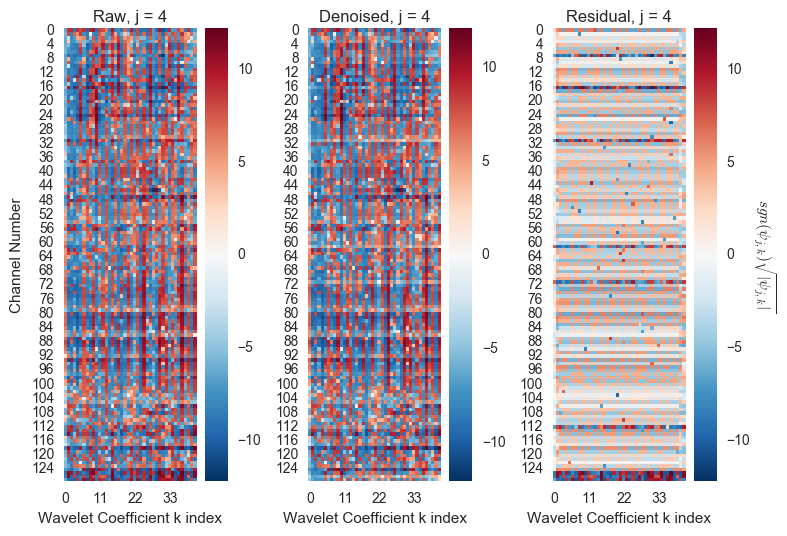

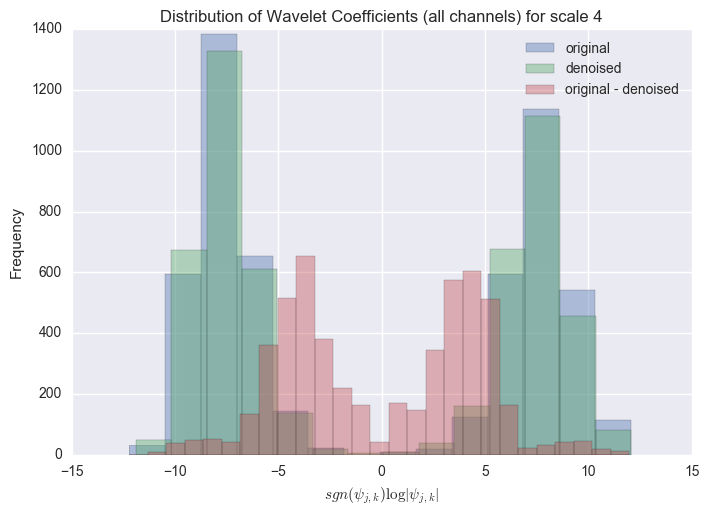

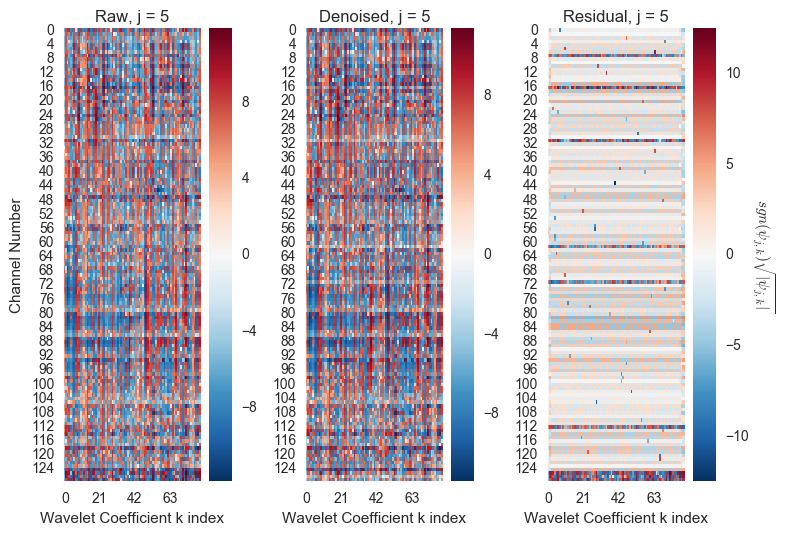

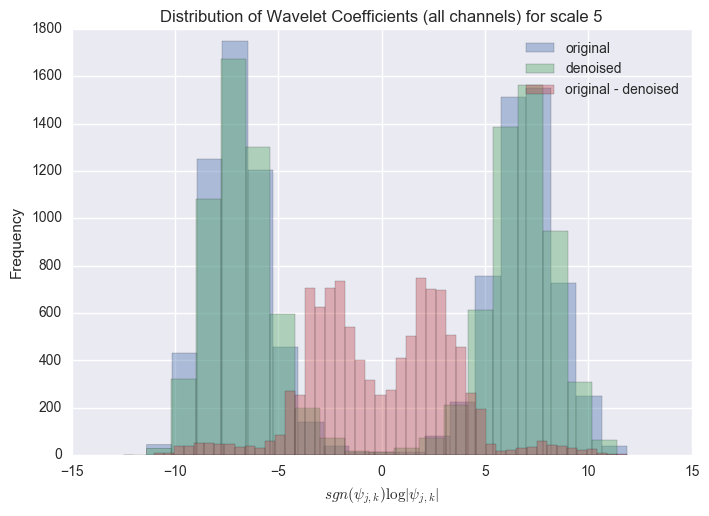

In [ ]:
#C_res = [np.array(x[0]) - np.array(x[1]) for x in zip(C, C_den)]
def cross_compare(reg, den, level):
    C_res = [np.array(x[0]) - np.array(x[1]) for x in zip(reg, den)]
    title = 'Raw'
    ax = plt.subplot(131)
    heat_level(reg, level, title, True)
    ax = plt.subplot(132)
    title = 'Denoised'
    heat_level(den, level, title)
    ax = plt.subplot(133)
    title = 'Residual'
    heat_level(C_res, level, title, False, True)
    plt.tight_layout()
    plt.show()
    
    dist_plot(reg, level, label = 'original')
    dist_plot(den, level, label = 'denoised')
    dist_plot(C_res, level, label = 'original - denoised')
    plt.xlabel(r'$sgn(\psi_{j, k})\log{\vert \psi_{j, k} \vert}$')
    plt.ylabel('Frequency')
    plt.title('Distribution of Wavelet Coefficients (all channels) for scale ' + str(level))
    plt.legend()
    plt.show()
cross_compare(C, C_int, 0)
cross_compare(C, C_int, 1)
cross_compare(C, C_int, 2)
cross_compare(C, C_int, 3)
cross_compare(C, C_int, 4)
cross_compare(C, C_int, 5)

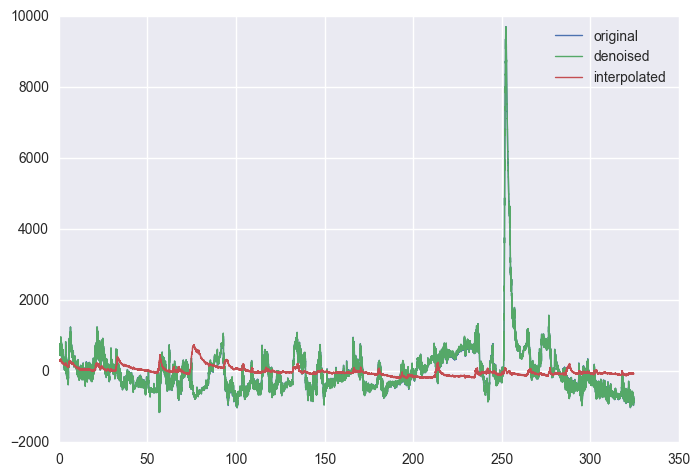

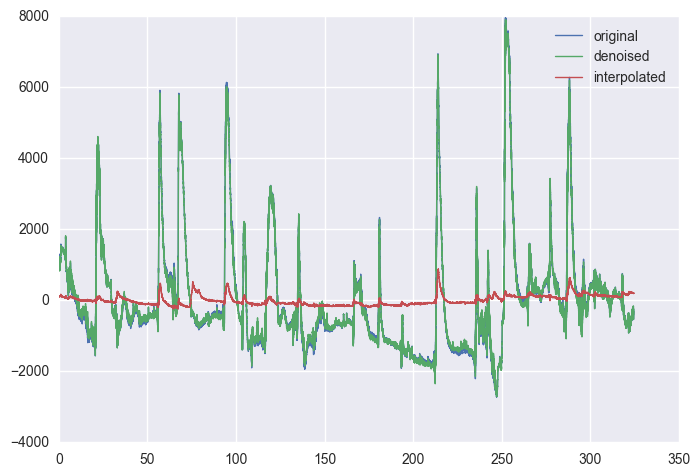

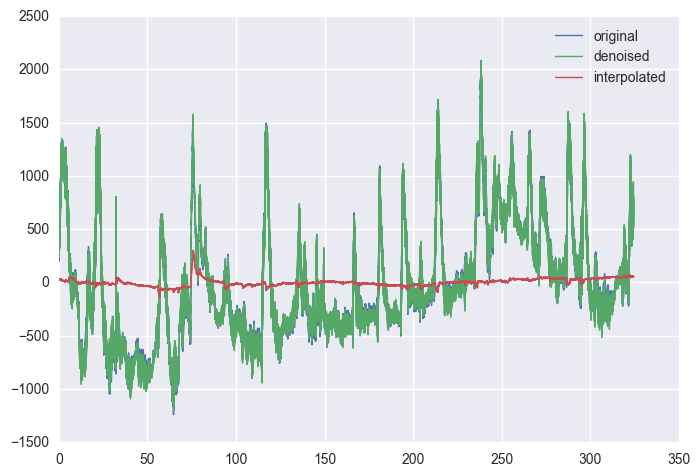

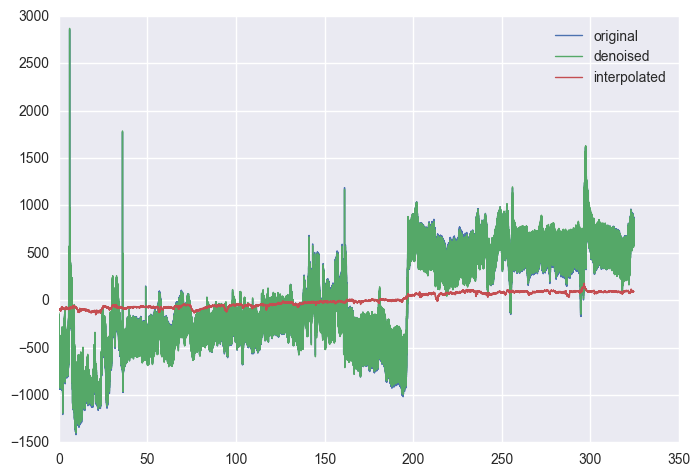

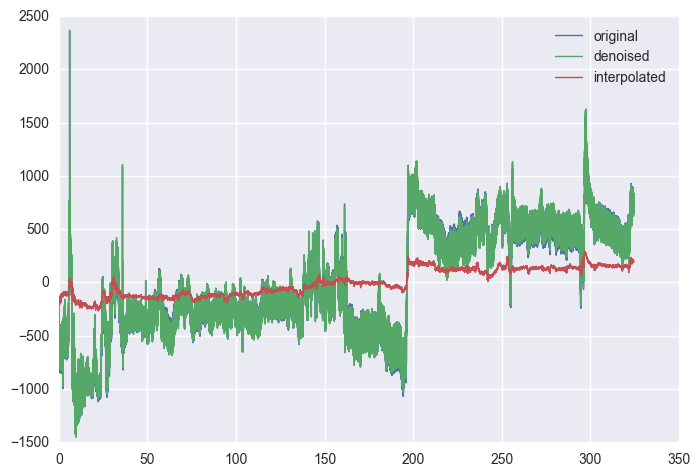

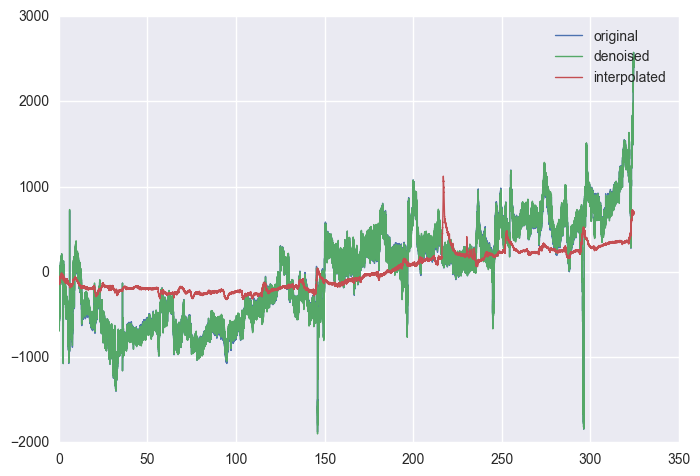

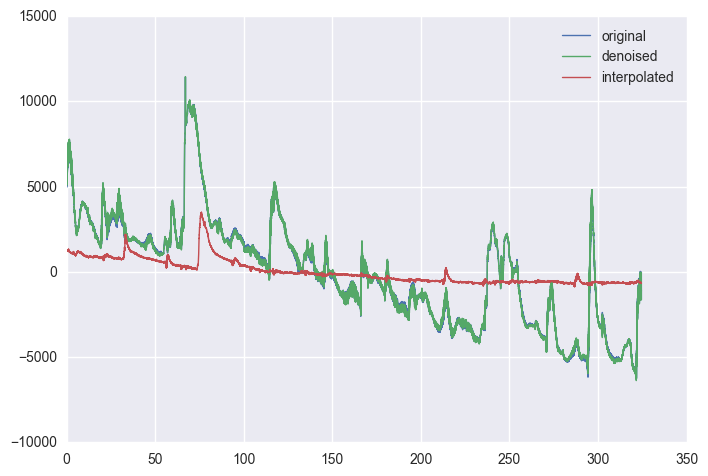

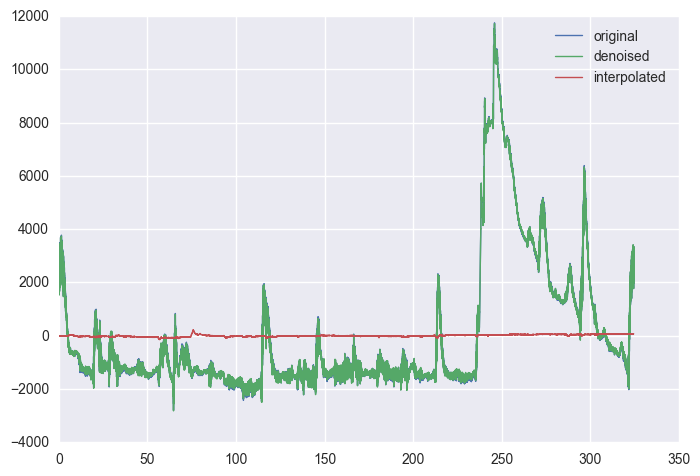

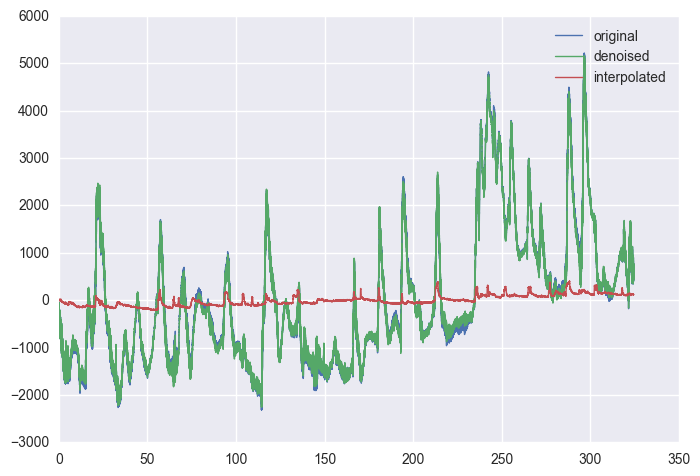

In [ ]:
timesteps = np.arange(f_real.shape[1])* 1./500
for channel in bad_chans:
    plt.plot(timesteps, f_real[channel, :], label='original', linewidth=1)
    plt.plot(timesteps, f_real_den[channel, :], label='denoised', linewidth=1)
    plt.plot(timesteps, f_real_int[channel, :], label='interpolated', linewidth=1)
    #plt.plot(timesteps, (f_real[channel, :] - f_real_int[channel, :]), label=r'$original - int$', linewidth=1)
    plt.legend()
    plt.show()
for channel in bad_chans:
    _, chans = closest(channel, chan_locs, np.setdiff1d(np.arange(128), bad_chans), 2)
    plt.plot(timesteps, f_real[channel, :], color='blue', linewidth = 1)
    for chan in chans:
        plt.plot(timesteps, f_real[chan, :], color='red', linewidth = 1)
    plt.plot(timesteps, f_real_int[channel, :], color='green', linewidth = 1)
    plt.show()

In [ ]:
errors = []
for c in range(f_real.shape[0]):
    errors.append(np.linalg.norm(f_real[c, :] - f_real_den[c, :]) / f_real.shape[1])
errors = np.array(errors)
#sns.distplot(errors)
#plt.show()
rg = np.argsort(errors)
#plt.plot(timesteps, f_real[np.argsort(errors)[-1]], color='red', linewidth=1)
#plt.plot(timesteps, f_real[np.argsort(errors)[0]], color='blue', linewidth=1)
#plt.plot(timesteps, f_real[np.argsort(errors)[-2]], color='red', linewidth=1)
#plt.plot(timesteps, f_real[np.argsort(errors)[1]], color='blue', linewidth=1)
#plt.plot(timesteps, f_real[np.argsort(errors)[-3]], color='red', linewidth=1)
#plt.plot(timesteps, f_real[np.argsort(errors)[2]], color='blue', linewidth=1)
plt.show()
m = 1
def oc(c):
    return [C[c - 1]]
def level(C, level):
    return np.array([c[level] for c in C])
#C_good = [C[rg[i]] for i in range(m)]
#C_bad = [C[rg[-(i + 1)]] for i in range(m)]
#dist_plot(C_good, 6, 'good')
#dist_plot(C_bad, 6, 'bad')
#dist_plot(oc(72), 6, 'test', kde = True)
#dist_plot(C, 6, 'all', kde = True)
#plt.legend()
#plt.show()
bad_chans = np.arange(128)
for i in range(len(C_den[0])):
    mu = np.mean(level(C_den, i), axis = 0)
    sig = np.std(level(C_den, i), axis = 0)
    zscores = [0] * 128
    for c in range(128):
        x = level(C_den, i)[c, :]
        d = (x - mu) / sig
        zscores[c] = zscores[c] + (np.linalg.norm(d, 3) / (i + 1))
sns.distplot(zscores)
plt.show()
print np.arange(1, 128 + 1)[np.array(zscores) > 8]
bad_chans = np.arange(128)[np.array(zscores) > 8]